In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

%matplotlib inline

from pathlib import Path
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.auto import tqdm

import captchanet

data_dir = Path('/home/hadim/.data/Neural_Network/captchanet')

dataset_dir = data_dir / 'dataset_v6'
train_data_dir = dataset_dir / 'training'
val_data_dir = dataset_dir / 'validation'

model_dir = data_dir / 'model'
model_name = 'v6'
model_path = model_dir / model_name

tokenizer_path = model_path / "tokenizer.json"

# Get tokenizer
with open(tokenizer_path) as f:
  #tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(f.read())
  from keras_preprocessing import text
  tokenizer = text.tokenizer_from_json(f.read())
  
model = tf.keras.models.load_model(str(model_path / 'model'))

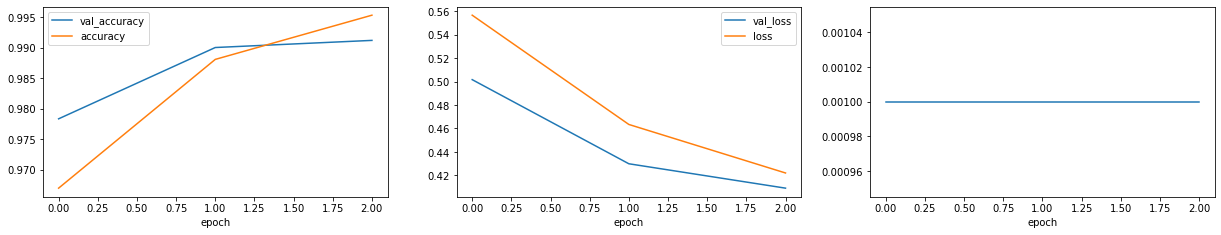

In [2]:
# Check history

history_path = model_path / 'history.csv'
history = pd.read_csv(history_path)

n = 3
size = 3.5
ncols = 3
w_h_scale = 2
figsize = (ncols * size * w_h_scale, size)
fig, axs = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=figsize)
axs = axs.flatten()

axs[0].plot(history['val_accuracy'], label='val_accuracy')
axs[0].plot(history['accuracy'], label='accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(history['val_loss'], label='val_loss')
axs[1].plot(history['loss'], label='loss')
axs[1].set_xlabel('epoch')
axs[1].legend()

axs[2].plot(history['lr'])
axs[2].set_xlabel('epoch')

fig.savefig(model_path / 'history.png')

W0714 00:52:51.968146 140595649144640 deprecation.py:323] From /home/hadim/local/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


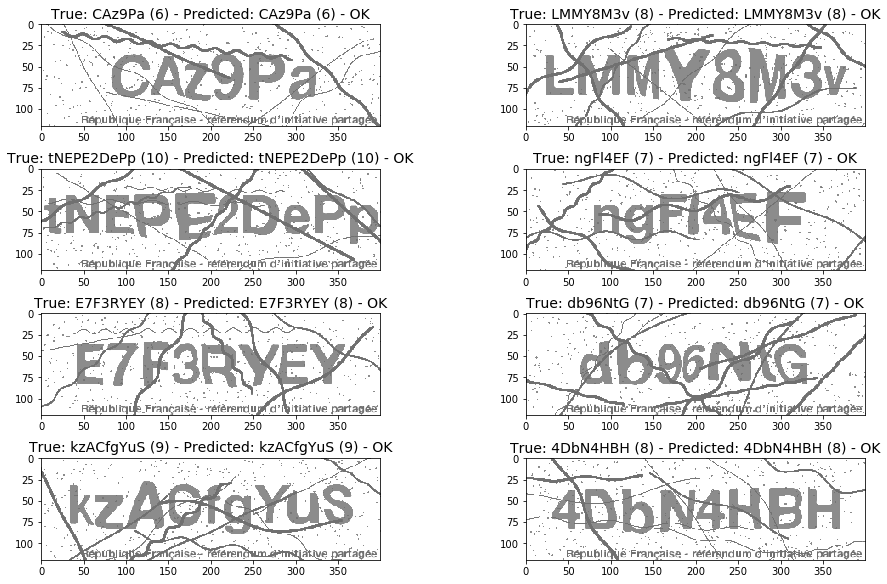

In [3]:
# Perform prediction
model_image_size = (224, 224)
n  = 8
fnames = [str(p) for p in val_data_dir.glob("*.tfrecord")]
dataset = tf.data.TFRecordDataset(fnames)
dataset = dataset.map(map_func=captchanet.decode_data(tokenizer, max_len_word=10, image_size=model_image_size, input_as_dict=True))
dataset = dataset.shuffle(1024)
dataset = dataset.batch(n)
data = [d for d in dataset.take(1)][0]

images = data['image']
labels = data['label']

labels = model(images)

# Decode
labels = labels.numpy().argmax(axis=2)
predicted_words = [tokenizer.sequences_to_texts([label])[0] for label in labels]
predicted_words = [word.replace(' ', '') for word in predicted_words]

# Plot
original_images = data['original_image'].numpy()
words = data['word'].numpy()
words = [w.decode('utf-8').replace('0', '') for w in words]

size = 2
ncols = 2
nrows = n // ncols
ratio = original_images.shape[2] / original_images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, predicted_word, ax in zip(original_images, words, predicted_words, axs):
  ax.imshow(image)
  
  mark = 'OK' if predicted_word == word else 'WRONG'
  text = f'True: {word} ({len(word)})'
  text += f' - Predicted: {predicted_word} ({len(predicted_word)})'
  text += f" - {mark}"
  ax.set_title(text, fontsize=14)
  
fig.savefig(model_path / 'example_prediction.png')

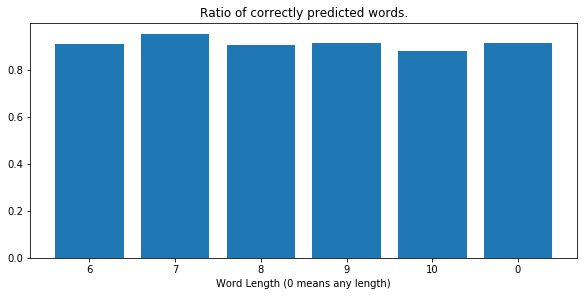

In [4]:
# Measure performance of the model

model_image_size = (224, 224)
n  = 24
fnames = [str(p) for p in val_data_dir.glob("*.tfrecord")]
dataset = tf.data.TFRecordDataset(fnames)
dataset = dataset.map(map_func=captchanet.decode_data(tokenizer, max_len_word=10, image_size=model_image_size, input_as_dict=True))
dataset = dataset.shuffle(1024)
dataset = dataset.batch(n)
data = [d for d in dataset.take(1)][0]

data = pd.DataFrame()

for datum in tqdm(dataset):
  
  images = datum['image']
  true_labels = datum['label']
  
  labels = model(images)

  labels = labels.numpy().argmax(axis=2)
  predicted_words = [tokenizer.sequences_to_texts([label])[0] for label in labels]
  predicted_words = [word.replace(' ', '') for word in predicted_words]

  true_labels = true_labels.numpy().argmax(axis=2)
  true_words = [tokenizer.sequences_to_texts([label])[0] for label in true_labels]
  true_words = [word.replace(' ', '') for word in true_words]
  
  datum = {}
  datum['correct_prediction'] = [true_word == predicted_word for true_word, predicted_word in zip(true_words, predicted_words)]
  datum['len_word'] = [len(true_word) for true_word in true_words]
  
  data = pd.concat([data, pd.DataFrame(datum)], ignore_index=True)
  
data = data.reset_index(drop=True)

correct_prediction_ratio = data['correct_prediction'].sum() / data.shape[0]

# Look at the ratio according to word length.

length_corret_predictions = data.groupby('len_word').sum() / data.groupby('len_word').count()
length_corret_predictions.loc[0] = correct_prediction_ratio

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

x_pos = np.arange(0, length_corret_predictions.shape[0])

ax.bar(x_pos, length_corret_predictions['correct_prediction'], align='center')

ax.set_xticks(x_pos)
ax.set_xticklabels(length_corret_predictions.index)

ax.set_xlabel("Word Length (0 means any length)")
ax.set_title("Ratio of correctly predicted words.")

fig.savefig(model_path / 'prediction_performance.png')

In [6]:
length_corret_predictions

,correct_prediction
len_word,
6,0.907143
7,0.951220
8,0.906250
9,0.912000
10,0.880952
0,0.913333
